In [1]:
%env THEANO_FLAGS="device=gpu1"

env: THEANO_FLAGS="device=gpu1"


In [2]:
import numpy as np
import theano
import theano.tensor as T
import lasagne
import os
import pickle

#thanks @keskarnitish

Using gpu device 1: GeForce GTX TITAN X (CNMeM is enabled with initial size: 95.0% of memory, cuDNN 5105)


In [3]:
import pandas as pd
names = pd.read_csv("/mnt/mainstore/data/izvestya.csv").title.values

start_token = " "
names = [start_token+name for name in names]

In [4]:
print(names[0])

 Арку ЦПКиО имени Горького разрушат и соберут по камушкам			


In [5]:
for x in names[::1000]:
    print(x)

n samples =  9974
 Арку ЦПКиО имени Горького разрушат и соберут по камушкам			
 Валерий Гергиев рассказал о Сергее Прокофьеве и Чулпан Хаматовой			
 «Что это за муж, если у него жена пляшет, как бесовка?»			
 Архив Тарковского поспособствует изданию книги об Абдрашитове			
 В «Библионочь» РГБ покажет спецхран и коллекцию Румянцева 			
 «У режиссеров комедий пользуется спросом инфантильный герой»			
 «Я решил себя проверить и показал «Левиафана» Говорухину»			
 Google запускает интернет-архив фронтовых писем 1941–1945 годов			
 «Я — логотип-наклейка группы «АукцЫон»			
 Вице-президент США Джо Байден побудет актером			


# Text processing

In [6]:
#all unique characters go here
token_set = set()
for name in names:
    for letter in name:
        token_set.add(letter)

tokens = list(token_set)

print('n_tokens = ',len(tokens))

n_tokens =  162


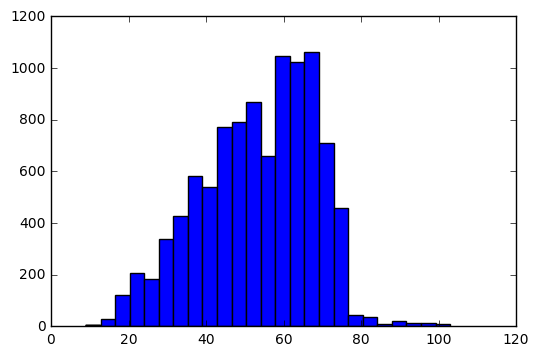

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(list(map(len,names)),bins=25);

# truncate names longer than MAX_LEN characters. 
MAX_LEN = min([80, max(list(map(len,names)))]) #TODO find out if 80 is okay
#ADJUST IF YOU ARE UP TO SOMETHING SERIOUS

### Cast everything from symbols into identifiers

In [8]:
token_to_id = {t:i for i,t in enumerate(tokens) }
id_to_token = {i:t for i,t in enumerate(tokens)}
names_ix = list(map(lambda name: list(map(token_to_id.get,name)),names))


#crop long names and pad short ones
for i in range(len(names_ix)):
    names_ix[i] = names_ix[i][:MAX_LEN] #crop too long
    
    if len(names_ix[i]) < MAX_LEN:
        names_ix[i] += [token_to_id[" "]]*(MAX_LEN - len(names_ix[i])) #pad too short
        
assert len(set(map(len,names_ix)))==1

names_ix = np.array(names_ix)

# Input variables

In [9]:
input_sequence = T.matrix('token sequencea','int32')
target_values = T.matrix('actual next token','int32')

# Build NN

You will be building a model that takes token sequence and predicts next token


* iput sequence
* one-hot / embedding
* recurrent layer(s)
* otput layer(s) that predict output probabilities


In [10]:
from lasagne.layers import InputLayer,DenseLayer,EmbeddingLayer
from lasagne.layers import RecurrentLayer,LSTMLayer,GRULayer,CustomRecurrentLayer

In [11]:
l_in = lasagne.layers.InputLayer(shape=(None, None),input_var=input_sequence)

#!<Your neural network>
l_emb = lasagne.layers.EmbeddingLayer(l_in, len(tokens), 40)

l_rnn1 = lasagne.layers.GRULayer(l_emb, 1024, grad_clipping=5)

l_rnn2 = lasagne.layers.LSTMLayer(l_rnn1, 1024, grad_clipping=5)

#flatten batch and time to be compatible with feedforward layers (will un-flatten later)
l_rnn_flat = lasagne.layers.reshape(l_rnn2, (-1,l_rnn2.output_shape[-1]))

l_out = lasagne.layers.DenseLayer(l_rnn_flat,len(tokens), nonlinearity=lasagne.nonlinearities.softmax)

In [64]:
# Model weights
weights = lasagne.layers.get_all_params(l_out,trainable=True)
print(len(weights))

27


In [79]:
from agentnet.utils.persistence import save,load
save(l_out,"agentnet_W.pcl")

In [71]:
network_output = lasagne.layers.get_output(l_out)
#If you use dropout do not forget to create deterministic version for evaluation

In [72]:
predicted_probabilities_flat = network_output
correct_answers_flat = target_values.ravel()


loss = T.mean(lasagne.objectives.categorical_crossentropy(predicted_probabilities_flat, correct_answers_flat))
#<Loss function - a simple categorical crossentropy will do, maybe add some regularizer>

updates = lasagne.updates.adam(loss,weights)

# Compiling it

In [73]:
#training
train = theano.function([input_sequence, target_values], loss, updates=updates, allow_input_downcast=True)

#computing loss without training
compute_cost = theano.function([input_sequence, target_values], loss, allow_input_downcast=True)

# generation

Simple: 
* get initial context(seed), 
* predict next token probabilities,
* sample next token, 
* add it to the context
* repeat from step 2

You'll get a more detailed info on how it works in the homework section.

In [74]:
#compile the function that computes probabilities for next token given previous text.

#reshape back into original shape
next_word_probas = network_output.reshape((input_sequence.shape[0],input_sequence.shape[1],len(tokens)))
#predictions for next tokens (after sequence end)
last_word_probas = next_word_probas[:,-1]
probs = theano.function([input_sequence],last_word_probas,allow_input_downcast=True)

In [102]:
from pyaspeller import Word
def correct_phrase(text):
    words = []
    for word in text.split():
        try:
            corrected = Word(word).spellsafe
        except Exception:
            pass
        corrected = corrected if corrected else word
        words.append(corrected)
    
    return ' '.join(words)

In [105]:
def generate_sample(seed_phrase=None,N=MAX_LEN,t=1,n_snippets=1):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
        
    parameters:
        sample_fun - max_ or proportional_sample_fun or whatever else you implemented
        
        The phrase is set using the variable seed_phrase

        The optional input "N" is used to set the number of characters of text to predict.     
    '''
    if seed_phrase is None:
        seed_phrase=start_token
    if len(seed_phrase) > MAX_LEN:
        seed_phrase = seed_phrase[-MAX_LEN:]
    assert type(seed_phrase) is str

    snippets = []
    for _ in range(n_snippets):
        sample_ix = []
        x = list(map(lambda c: token_to_id.get(c,0), seed_phrase))
        x = np.array([x])

        for i in range(N):
            # Pick the character that got assigned the highest probability
            p = probs(x).ravel()
            p = p**t / np.sum(p**t)
            ix = np.random.choice(np.arange(len(tokens)),p=p)
            sample_ix.append(ix)

            x = np.hstack((x[-MAX_LEN+1:],[[ix]]))

        random_snippet = seed_phrase + ''.join(id_to_token[ix] for ix in sample_ix)    
        snippets.append(random_snippet)
        
    print(correct_phrase("----\n %s \n----" % '; '.join(snippets)), '/n')
#     return correct_phrase("----\n %s \n----" % '; '.join(snippets))

In [106]:
generate_sample(" abc")

---- abba Sotheby’s отметили велосипеда и Джиобят в голове ---- /n


# Model training

Here you can tweak parameters or insert your generation function


__Once something word-like starts generating, try increasing seq_length__



In [58]:
def sample_batch(data, batch_size):
    
    rows = data[np.random.randint(0,len(data),size=batch_size)]
    
    return rows[:,:-1],rows[:,1:]

In [107]:
print("Training ...")


#total N iterations
n_epochs=100

# how many minibatches are there in the epoch 
batches_per_epoch = 500

#how many training sequences are processed in a single function call
batch_size=10


for epoch in range(n_epochs):

    print("Generated names")
    generate_sample(n_snippets=10,t=2)

    avg_cost = 0;
    
    for _ in range(batches_per_epoch):
        
        x,y = sample_batch(names_ix,batch_size)
        avg_cost += train(x, y)
        
    print("Epoch {} average loss = {}".format(epoch, avg_cost / batches_per_epoch))
    if epoch%5 == 0:
        with open("full_w_{}.pcl".format(epoch),'wb') as f:
            pickle.dump([lasagne.layers.get_all_param_values(l_out),tokens,token_to_id, id_to_token],f)
    generate_sample(seed_phrase=" Stepic",n_snippets=10,t=5)

Training ...
Generated names
---- «Доктор Стрэндж» в кислотной сцены ; Большой театр открыл сезон «Машину» Московском фильме ; В Москве пройдет фестиваль «Букера» в Москве ; Кино поколение next выбирает комедию ; Максим Аверин: «В Москве на планетарий на площадка» ; В Москве пройдет юбилей Геннадия Роткоопой ; «В Москве показали не дают подам не случайно ; «В России много получат влюбили все значение в общества» ; Объявлены финалисты литературной премии Белкина ; «Если у как самим, сделать свой музыки был проявку сс ---- /n
Epoch 0 average loss = 0.2781638117134571
---- Stepictur gas в поддержку Филина букет по версии Дмитриенко ; Stepictur на сцену ; Stepictur gris появилась «Легенды № 17», an LOL Deep и платы в анимации» ; Stepictur grace как в Москве на «Небервые открытые карах» ; Stepsister показов для взрослых нацизм ; Stepsister показывает выставку Рафикции на «Легенды человека» ; Stepictur картин «Тангелейзера» в новой роли ; Stepictur картин «Тангелевски «Нашествия на браке ; S

KeyboardInterrupt: 

In [110]:
gen = generate_sample(seed_phrase=" Ну блин",n_snippets=10,t=2)

---- Ну блинке надо выставку «Современники у Сергей Детектор ; Ну блинке закрыта на словного Гаспонарда ; Ну блине Аквариум и Жданова ; Ну блины Римминоиславших переходатолись на русском музее ; Ну блинку-биле Большого театра начал «Золотого глобуса» ; Ну блине Американцы переходу Ли ; Ну блины Риме Рязанова устала идею Виктора Полевой ; Ну Блинова признак Смоленском людям на площади ; Ну блины Римминосцева много чередования киноакадемии — выживания переходи ; Ну блинки не в Стрэнджели ---- /n


# And now,
* try lstm/gru
* try several layers
* try mtg cards
* try your own dataset of any kind

In [99]:
correct_phrase(gen.replace("'", '').split('\t'))

''